In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [3]:
q = """SELECT npi, nppes_provider_last_org_name, nppes_provider_state, nppes_provider_first_name,
provider_type, hcpcs_code, hcpcs_description, bene_unique_cnt
FROM payments 
WHERE (provider_type='Medical Oncology' OR provider_type='Hematology/Oncology')
AND place_of_service='O'
AND hcpcs_drug_indicator='Y'"""
payments = pd.read_sql_query(q, con=con)

## get list of chemo drugs

In [4]:
# How many drugs are chemo/non chemo or neither?
def drug_category_count(drugs):
    """Count drugs per category, A,B,C
    input - list of hcpcs codes for drugs
    returns - list of drugs per category and error list containing drugs that don't fall in any category
    
    # A : J0000 - J8499 --- drugs other than chemo
    # B : J8521 - J9999 --- chemo drugs
    # C : Doesn't begin with 'J'
    """
    A = []
    B = []
    C = []
    
    countA = 0
    countB = 0
    countC = 0
    errorlist = []  # list of drugs that don't fall in either category
    for d in drugs:
        if d[0].upper() == 'J':
            if int(d[1:]) >= 0 and int(d[1:]) <= 8499:
                countA += 1
                A.append(d)
            elif int(d[1:]) >= 8521 and int(d[1:]) <= 9999:
                countB += 1
                B.append(d)
            else:
                errorlist.append(d)
        else:
            countC += 1
            C.append(d)
    
    print("drugs other than chemo: {0}; \n chemo drugs: {1}; \n drugs that don't start with J: {2}".format(countA, countB, countC))
    return A, B, C, errorlist

In [7]:
nonchemo_drugs, chemo_drugs, other_drugs, error_drugs = drug_category_count(payments.drop_duplicates('hcpcs_code')['hcpcs_code'])

drugs other than chemo: 109; 
 chemo drugs: 38; 
 drugs that don't start with J: 28


In [8]:
## make them strings
nonchemo_drugs = [str(x) for x in nonchemo_drugs]
chemo_drugs = [str(x) for x in chemo_drugs]
other_drugs = [str(x) for x in other_drugs]

In [10]:
payments_chemo = payments[payments.hcpcs_code.isin(chemo_drugs)]

In [11]:
payments_chemo.shape

(12074, 8)

## make provider - features  matrix based only on chemo drugs

In [12]:
by_npi = (payments_chemo[['npi','hcpcs_code','bene_unique_cnt']].
                        pivot(index='npi', values = 'bene_unique_cnt', columns='hcpcs_code').
                        fillna(value=0))
by_npi.shape

(2749, 38)

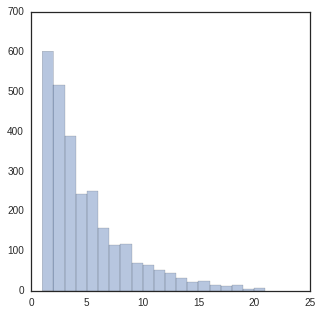

In [31]:
## How many distinct claims are there per provider?
sns.distplot(by_npi.astype(bool).sum(axis=1), bins = 20, kde=False)

In [32]:
## How many providers have more than 10 claims of chemo drugs?
sum(by_npi.astype(bool).sum(axis=1) > 10)

227

In [33]:
## Let's get bool idx of these providers
more_than_10_claims = (by_npi.astype(bool).sum(axis=1) > 10).astype(bool)

In [34]:
more_than_10_claims.shape

(2749,)

## t-SNE on raw chemo matrix

In [13]:
from sklearn.manifold import TSNE

In [14]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2749
[t-SNE] Computed conditional probabilities for sample 2000 / 2749
[t-SNE] Computed conditional probabilities for sample 2749 / 2749
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.6239439, gradient norm = 0.0075969
[t-SNE] Iteration 50: error = 1.4553741, gradient norm = 0.0058192
[t-SNE] Iteration 75: error = 0.9609157, gradient norm = 0.0032217
[t-SNE] Iteration 100: error = 0.8722639, gradient norm = 0.0032608
[t-SNE] Error after 100 iterations with early exaggeration: 0.872264
[t-SNE] Iteration 125: error = 0.7322443, gradient norm = 0.0025049
[t-SNE] Iteration 150: error = 0.6899453, gradient norm = 0.0027051
[t-SNE] Iteration 175: error = 0.7003593, gradient norm = 0.0027941
[t-SNE] Iteration 200: error = 0.6979607, gradient norm = 0.0019223
[t-SNE] Iteration 200: did not make any progress during the last 30 episodes. Fi

In [15]:
color_codes = (pd.DataFrame({'npi':by_npi.index}).
               merge(payments.drop_duplicates('npi')[['npi', 'provider_type']]))

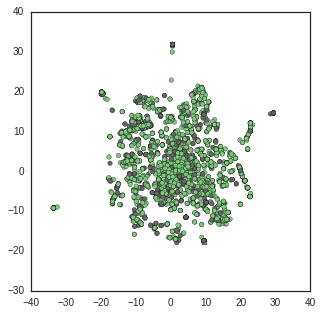

In [18]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.scatter(X_embedded[:,0], X_embedded[:,1], 
            c=color_codes.provider_type.astype('category').cat.codes,
            cmap = 'Accent')

## PCA on raw chemo matrix

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

In [21]:
X_centered = preprocessing.scale(by_npi.as_matrix(), with_mean=True, with_std=False)
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced = svd.fit_transform(X_centered)
svd.explained_variance_ratio_

array([ 0.45278074,  0.08936298,  0.07062672])

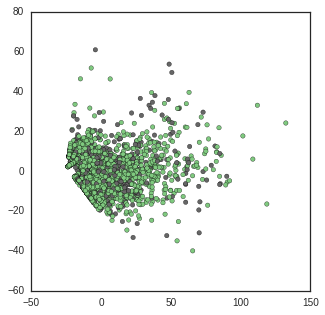

In [23]:
## pc1 & pc2
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=color_codes.provider_type.astype('category').cat.codes,
            cmap = 'Accent')

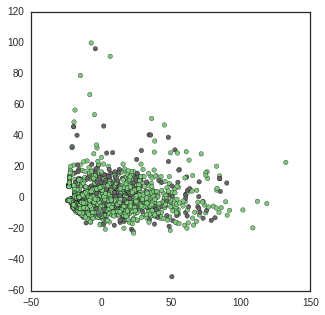

In [24]:
## pc1 & pc3
plt.scatter(X_reduced[:,0], X_reduced[:,2], c=color_codes.provider_type.astype('category').cat.codes,
            cmap = 'Accent')

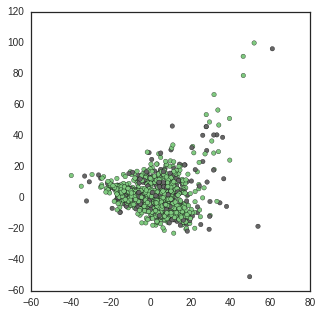

In [25]:
## pc2 & pc3
plt.scatter(X_reduced[:,1], X_reduced[:,2], c=color_codes.provider_type.astype('category').cat.codes,
            cmap = 'Accent')

## t-SNE on only the 227 providers with > 10 claims

In [36]:
X_embedded1 = (TSNE(n_components=2, perplexity=40, verbose=2).
               fit_transform(by_npi[more_than_10_claims].as_matrix()))

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 227 / 227
[t-SNE] Mean sigma: 19.420372
[t-SNE] Iteration 25: error = 0.9582094, gradient norm = 0.0222117
[t-SNE] Iteration 50: error = 1.2554102, gradient norm = 0.0251503
[t-SNE] Iteration 75: error = 2.0028358, gradient norm = 0.0400368
[t-SNE] Iteration 100: error = 2.1672361, gradient norm = 0.0049629
[t-SNE] Error after 100 iterations with early exaggeration: 2.167236
[t-SNE] Iteration 125: error = 2.0336053, gradient norm = 0.0011098
[t-SNE] Iteration 150: error = 2.0023990, gradient norm = 0.0010037
[t-SNE] Iteration 175: error = 1.9941190, gradient norm = 0.0010135
[t-SNE] Iteration 200: error = 1.9917147, gradient norm = 0.0010163
[t-SNE] Iteration 225: error = 1.9910382, gradient norm = 0.0010174
[t-SNE] Iteration 250: error = 1.9908465, gradient norm = 0.0010176
[t-SNE] Iteration 275: error = 1.9907941, gradient norm = 0.0010177
[t-SNE] I

In [37]:
color_codes1 = (pd.DataFrame({'npi':by_npi[more_than_10_claims].index}).
               merge(payments.drop_duplicates('npi')[['npi', 'provider_type']]))

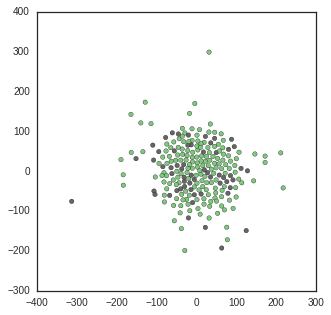

In [38]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.scatter(X_embedded1[:,0], X_embedded1[:,1], 
            c=color_codes1.provider_type.astype('category').cat.codes,
            cmap = 'Accent')